In [34]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForMaskedLM,BertTokenizer, BertModel
from transformers import FillMaskPipeline
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import joblib
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import scipy.stats as st
from matplotlib import colors
import researchpy as rp

In [2]:
bert_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased",
           output_hidden_states = True)
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

fin_model = AutoModelForMaskedLM.from_pretrained("yiyanghkust/finbert-pretrain", output_hidden_states = True)
fin_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-pretrain")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassific

In [3]:
bert_pipe = FillMaskPipeline(bert_model,bert_tokenizer)
fin_pipe = FillMaskPipeline(fin_model,fin_tokenizer)

In [80]:
def get_prob(pipe , name):
    res = pipe(f'We should [MASK] the {name} stock.' , targets=["buy", "sell"])
    output = []
    for i in res:
        output.append(i["score"])
    return output

In [133]:
df = pd.read_excel("russell3000_ticker_GIC.xlsx")
df1 = df.copy().dropna()
symbol = df1["Symbol"].to_list()
name = df1["Description"].to_list()
sector = df1["gsector"].to_list()
sector_set = list(set(sector))
sec_map = ["Energy","Materials","Industrials","Consumer Discretionary","Consumer Staples","	Health Care","Financials","Information Technology","Communication Services","Utilities","Real Estate"]

In [106]:
## with name
name_bert_output = []
name_fin_output = []
for i , e in enumerate(tqdm(name)):
    name_bert_output.append(get_prob(bert_pipe, e))
    name_fin_output.append(get_prob(fin_pipe, e))

100%|██████████| 2650/2650 [05:41<00:00,  7.75it/s]


In [108]:
name_bert_buy = [i[0] for i in name_bert_output]
name_bert_sell = [i[1] for i in name_bert_output]
name_fin_buy = [i[0] for i in name_fin_output]
name_fin_sell = [i[1] for i in name_fin_output]

name_bert_res = np.divide(np.array(name_bert_buy), np.add(name_bert_sell,name_bert_buy))
name_fin_res = np.divide(np.array(name_fin_buy), np.add(name_fin_sell,name_fin_buy))

In [109]:
sec = pd.get_dummies(sector)
sector_vec = sec.T.to_numpy().reshape(11,2650)

In [110]:
def get_p_value(model, sector_vec):
    output = []
    for i in tqdm(sector_vec):
        X = sm.add_constant(i)
#         Y1 = [j[1] for j in model]
        p0 = sm.OLS(model, X).fit()
#         p1 = sm.OLS(Y1, X).fit().f_pvalue
        output.append(p0)
    return output

name_bert_p = get_p_value(name_bert_buy, sector_vec)
name_fin_p = get_p_value(name_fin_buy, sector_vec)

100%|██████████| 11/11 [00:00<00:00, 700.27it/s]


In [112]:
sec_index_temp = {}

for i , el in enumerate(sector):
    if el not in sec_index_temp.keys():
        sec_index_temp[el] = [i]
    else:
        sec_index_temp[el].append(i)
sec_index = []
for i in sec_index_temp.keys():
    sec_index.append(sec_index_temp[i])
    

def get_bias(p_model):
    buy_bias = {}
    for i , p in enumerate(p_model):
        if p.f_pvalue < 0.05:
            buy_bias["*"+sec_map[i]+"*"] = p.params[1]
        else:
            buy_bias[sec_map[i]] = p.params[1]
    return {"buy":buy_bias}


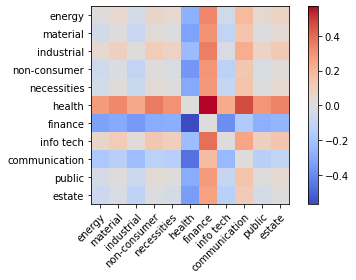

{'buy': {'energy': 0.0014802360637915944,
  '*material*': 0.022192146238281318,
  'industrial': 0.004266615649704781,
  'non-consumer': 0.001653759724440641,
  'necessities': 0.007295206721126005,
  'health': 5.451128769377663e-05,
  '*finance*': -0.008765168151571271,
  'info tech': 0.0011986799838965187,
  'communication': -0.0007069592834604466,
  'public': 0.006060845159028445,
  '*estate*': -0.01881124867765544}}

In [115]:
sec_sim_buy = []

for i in sec_index:
    temp = []
    for j in i:
        temp.append(name_bert_buy[j])
    sec_sim_buy.append(temp)
sec_sim_buy_res = []
for i in range(len(sec_sim_buy)):
    for j in range(len(sec_sim_buy)):
        sec_sim_buy_res.append(rp.ttest(pd.Series(sec_sim_buy[i]),pd.Series(sec_sim_buy[j]),equal_variances= False)[1].iloc[6,1])

square_sim_buy = np.reshape(sec_sim_buy_res, (11,11))

fig, ax = plt.subplots()
cmap = colors.ListedColormap(["navy", "royalblue", "lightsteelblue", 
                              "beige", "peachpuff", "salmon", "darkred"])
cmap = matplotlib.cm.coolwarm
im = ax.imshow(square_sim_buy,cmap=cmap)
ax.set_xticks(np.arange(len(sec_map)))
ax.set_yticks(np.arange(len(sec_map)))
ax.set_xticklabels(sec_map)
ax.set_yticklabels(sec_map)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(im)
ax.set_title("")
fig.tight_layout()
plt.show()

get_bias(name_bert_p)

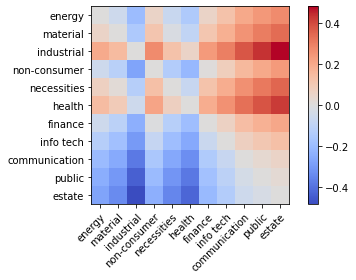

{'buy': {'energy': 0.0071992247907051755,
  '*material*': 0.010938970782456807,
  'industrial': 0.004017178879305759,
  '*non-consumer*': -0.00942544216303718,
  'necessities': -0.00297783049527747,
  'health': 0.001016616197043385,
  '*finance*': -0.008257378164326345,
  '*info tech*': 0.007031993178473249,
  '*communication*': -0.009820001067976796,
  '*public*': 0.013463445085416626,
  'estate': 0.0007286563317389453}}

In [116]:
sec_sim_buy = []

for i in sec_index:
    temp = []
    for j in i:
        temp.append(name_fin_buy[j])
    sec_sim_buy.append(temp)
sec_sim_buy_res = []
for i in range(len(sec_sim_buy)):
    for j in range(len(sec_sim_buy)):
        sec_sim_buy_res.append(rp.ttest(pd.Series(sec_sim_buy[i]),pd.Series(sec_sim_buy[j]),equal_variances= False)[1].iloc[6,1])

square_sim_buy = np.reshape(sec_sim_buy_res, (11,11))

fig, ax = plt.subplots()
cmap = colors.ListedColormap(["navy", "royalblue", "lightsteelblue", 
                              "beige", "peachpuff", "salmon", "darkred"])
cmap = matplotlib.cm.coolwarm
im = ax.imshow(square_sim_buy,cmap=cmap)
# im = ax.imshow(square_sim_buy,cmap=cm.Reds)
# ax = sns.heatmap(square_sim_buy)
# We want to show all ticks...
ax.set_xticks(np.arange(len(sec_map)))
ax.set_yticks(np.arange(len(sec_map)))
# ... and label them with the respective list entries
ax.set_xticklabels(sec_map)
ax.set_yticklabels(sec_map)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(im)
# plt.title(f"Heat Map of Cross Industry \np-value \nby their effect-size with Name and FinBert")
fig.tight_layout()
plt.show()

get_bias(name_fin_p)

## SEAT

In [124]:
def bert_text_preparation(text, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[1][1:]
    token_embeddings = hidden_states[-1]
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

def get_embed(text , model , tokenizer):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)

    # Find the position 'bank' in list of tokens
    #     word_index = tokenized_text.index('Buy')
    # Get the embedding for bank
    word_embedding = list_token_embeddings[:]
    return word_embedding[0]


def seat(sen ,model, tokenizer):
    one = get_embed(sen[0] , model ,tokenizer)
    two = get_embed(sen[1] , model, tokenizer)
    return 1- cosine(one,two)

seat_sim_bert = []
seat_sim_fin = []
seat_sim_bert_sell=[]
seat_sim_fin_sell = []
for i in tqdm(name):
    sen1 = f'{i} is a stock.'
    sen2 = "We should buy the stock."
    sen3 = "We should sell the stock."
    seat_sim_bert.append(seat([sen1,sen2],bert_model, bert_tokenizer))
    seat_sim_fin.append(seat([sen1,sen2],fin_model, fin_tokenizer))
    seat_sim_bert_sell.append(seat([sen1,sen3],bert_model, bert_tokenizer))
    seat_sim_fin_sell.append(seat([sen1,sen3],fin_model, fin_tokenizer))

100%|██████████| 2650/2650 [09:42<00:00,  4.55it/s]


In [131]:
### used for seat in main paper cohen's d
for i , vec in enumerate(sector_vec):
    X = []
    NotX = []
    for j , el in enumerate(vec):
        if el == 1:
            X.append(seat_sim_bert[j])
        else:
            NotX.append(seat_sim_bert_sell[j])
    p = stats.ttest_ind(a=X, b=NotX, equal_var=False)
    p1 = rp.ttest(pd.Series(X),pd.Series(NotX),equal_variances= False)[1]
    print(sec_map[i], "Cohen's d: " , p1.iloc[6,1])

energy Cohen's d:  -0.5564
material Cohen's d:  -0.1469
industrial Cohen's d:  0.1854
non-consumer Cohen's d:  0.2549
necessities Cohen's d:  -0.0788
health Cohen's d:  0.055
finance Cohen's d:  -0.6534
info tech Cohen's d:  0.4433
communication Cohen's d:  0.1044
public Cohen's d:  -0.1904
estate Cohen's d:  0.0004
